<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

# Relevance Reasoning with pyAgrum

Relevance reasoning is the analysis of the influence of evidence on a Bayesian Network. 

In this notebook we will explain what is relevance reasoning and how to do it using pyAgrum.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import time
import os
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

## Multiple inference

In the well known 'alarm' BN, how to analyze the influence on 'VENTALV' of a soft evidence on 'MINVOLSET' ?

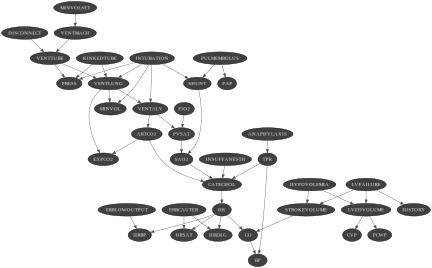

In [2]:
bn=gum.loadBN(os.path.join("res","alarm.dsl"))
gnb.showBN(bn,size="6")

We propose to draw the plot of the posterior of 'VENTALV' for the evidence : $$\forall x \in [0,1], e_{MINVOLSET}=[0,x,0.5]$$

To do so, we perform a large number of inference and plot the posteriors.

In [3]:
K=1000
r=range(0,K)
xs=[x/K for x in r]

def getPlot(xs,ys,K,duration):
    p=plot(xs,ys)
    legend(p,[bn.variableFromName('VENTALV').label(i) 
              for i in range(bn.variableFromName('VENTALV').domainSize())],loc=7);
    title('VENTALV ({} inferences in {} s)'.format(K,duration));
    ylabel('posterior Probability');
    xlabel('Evidence on MINVOLSET : [0,x,0.5]');

## First try : classical lazy inference

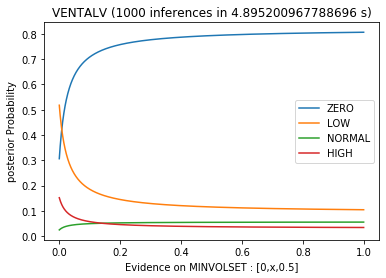

In [4]:
tf=time.time()
ys=[]
for x in r:
    ie=gum.LazyPropagation(bn)
    ie.addEvidence('MINVOLSET',[0,x/K,0.5])
    ie.makeInference()
    ys.append(ie.posterior('VENTALV').tolist())
delta1=time.time()-tf
getPlot(xs,ys,K,delta1)

## Second try : classical variable elimination

One can note that we just need one posterior. This is a case where VariableElimination should give best results.

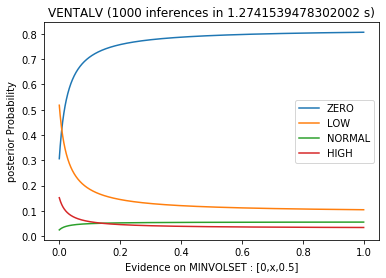

In [5]:
tf=time.time()
ys=[]
for x in r:
    ie=gum.VariableElimination(bn)
    ie.addEvidence('MINVOLSET',[0,x/K,0.5])
    ie.makeInference()
    ys.append(ie.posterior('VENTALV').tolist())
delta2=time.time()-tf
getPlot(xs,ys,K,delta2)

pyAgrum give us a function `gum.getPosterior` to do this same job more easily.

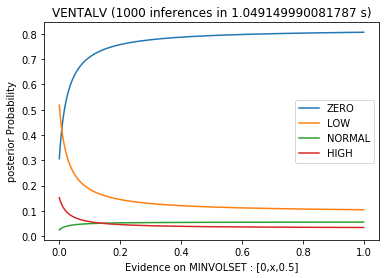

In [6]:
tf=time.time()
ys=[gum.getPosterior(bn,{'MINVOLSET':[0,x/K,0.5]},'VENTALV').tolist() 
        for x in r]
getPlot(xs,ys,K,time.time()-tf)

## Last try : optimized Lazy propagation with relevance reasoning and incremental inference

Optimized inference in aGrUM can use the targets and the evidence to optimize the computations. This is called **relevance reasonning**.

Moreover, if the values of the evidence change but not the structure of the query (same nodes as target, same nodes as hard evidence, same nodes as soft evidence), inference in aGrUM may re-use some of the computations from a query to another. This is called **incremental inference**.

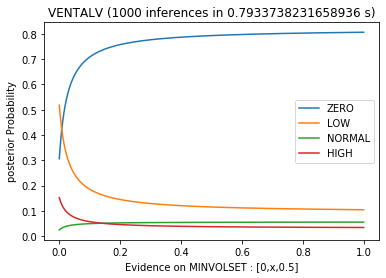

In [7]:
tf=time.time()
ie=gum.VariableElimination(bn)
ie.addEvidence('MINVOLSET',[1,1,1])
ie.addTarget('VENTALV')
ys=[]
for x in r:
    ie.chgEvidence('MINVOLSET',[0,x/K,0.5])
    ie.makeInference()
    ys.append(ie.posterior('VENTALV').tolist())
delta3=time.time()-tf
getPlot(xs,ys,K,delta3)

In [8]:
print("Mean duration of a lazy propagation            : {:5.3f}ms".format(1000*delta1/K))
print("Mean duration of a variable elimination        : {:5.3f}ms".format(1000*delta2/K))
print("Mean duration of an optimized lazy propagation : {:5.3f}ms".format(1000*delta3/K))

Mean duration of a lazy propagation            : 4.895ms
Mean duration of a variable elimination        : 1.274ms
Mean duration of an optimized lazy propagation : 0.793ms


# How it works


In [9]:
bn=gum.fastBN("Y->X->T1;Z2->X;Z1->X;Z1->T1;Z1->Z3->T2")
ie=gum.LazyPropagation(bn)

gnb.sideBySide(bn,
               bn.cpt("X"),
               gnb.getJunctionTree(bn),
               captions=["BN","potential","Junction Tree"])

<h3>aGrUM/pyAgrum use as much as possible techniques of relevance reasonning to reduce the complexity of the inference.</h3>

In [10]:
print(ie.BN().arcs())
ie.setEvidence({"X":0})
gnb.sideBySide(ie,gnb.getDot(ie.joinTree().toDotWithNames(bn)),
               captions=["","Join tree optimized for hard evidence on X"])

{(0, 1), (1, 2), (4, 5), (5, 6), (3, 1), (4, 2), (4, 1)}


In [11]:
ie.updateEvidence({"X":[0.1,0.9]})
gnb.sideBySide(ie,gnb.getDot(ie.joinTree().toDotWithNames(bn)),
               captions=["","Join tree optimized for soft evidence on X"])

In [12]:
ie.updateEvidence({"Y":0,"X":0,3:[0.1,0.9],"Z1":[0.4,0.6]})
gnb.sideBySide(ie,gnb.getDot(ie.joinTree().toDotWithNames(bn)),
               captions=["","Join tree optimized for hard evidence on X and Y, soft on Z2 and Z1"])

In [13]:
ie.setEvidence({"X":0})
ie.setTargets({"T1","Z1"})
gnb.sideBySide(ie,gnb.getDot(ie.joinTree().toDotWithNames(bn)),
               captions=["","Join tree optimized for hard evidence on X and targets T1,Z1"])

In [14]:
ie.updateEvidence({"Y":0,"X":0,3:[0.1,0.9],"Z1":[0.4,0.6]})
ie.addJointTarget({"Z2","Z1","T1"})

gnb.sideBySide(ie,
               gnb.getDot(ie.joinTree().toDotWithNames(bn)),
               captions=["","Join tree optimized for hard evidence on X and targets T1,Z1"])

In [15]:
ie.makeInference()
ie.jointPosterior({"Z2","Z1","T1"})

(gum::Potential<double>@0x7f8859d13da0) <Z1:0|T1:0|Z2:0> :: 0.000480806 /<Z1:1|T1:0|Z2:0> :: 0.0150232 /<Z1:0|T1:1|Z2:0> :: 0.0181182 /<Z1:1|T1:1|Z2:0> :: 0.0506179 /<Z1:0|T1:0|Z2:1> :: 0.00867767 /<Z1:1|T1:0|Z2:1> :: 0.132762 /<Z1:0|T1:1|Z2:1> :: 0.327001 /<Z1:1|T1:1|Z2:1> :: 0.447319

In [16]:
ie.jointPosterior({"Z2","Z1"})

(gum::Potential<double>@0x7f8899c14050) <Z1:0|Z2:0> :: 0.018599 /<Z1:1|Z2:0> :: 0.065641 /<Z1:0|Z2:1> :: 0.335678 /<Z1:1|Z2:1> :: 0.580082

In [17]:
# this will not work 
try:
    ie.jointPosterior({"Z3","Z1"})
except gum.UndefinedElement:  
    print("Indeed, there is no joint target which contains {4,5} !")

Indeed, there is no joint target which contains {4,5} !


In [18]:
ie.addJointTarget({"Z2","Z1"})
gnb.sideBySide(ie,
               gnb.getDot(ie.joinTree().toDotWithNames(bn)),
              captions=['','JoinTree'])